In [1]:
import numpy as np 
import re
import pandas as pd 
from pprint import pprint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, save_model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import os
from gensim.models import FastText,KeyedVectors
from keras.utils import to_categorical
import time
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.preprocessing import MultiLabelBinarizer
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ner-datas/label_data.txt
/kaggle/input/ner-datas/labeled_data.txt
/kaggle/input/bengaliword2vec/bn_w2v_model.text
/kaggle/input/bengaliword2vec/bn_w2v_model.bin


In [2]:
data=pd.read_csv("/kaggle/input/ner-datas/label_data.txt",encoding="utf-8",sep=" ",names=['word','label'],skip_blank_lines=False)
df=pd.DataFrame(data)
df.replace(np.NaN,"Break",inplace=True)

In [3]:
#checking empty list
def remove_empty_list(data):
    a=list(filter(lambda x: [] != x, data))
    return a

#for spiliting sentences
def making_list(data):
    f=[]
    t=[]
    for i in data:
        if (i=="Break"):
            f.append(t)
            t=[]
        else:
            t.append(i)
    return remove_empty_list(f)

def data_preprocessing():
    label=making_list(df['label'])
    sen=making_list(df['word'])
    l=[]
    for i in sen:
        s=" ".join(i)
        l.append(preprocessing(s).split())
    max_len=max([len(i) for i in sen])
    return sen,label,max_len

def preprocessing(sentence):
    whitespace = re.compile(u"[\ufeff\u200d\u200b\u200c\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
    fullspace = re.compile(u"[\s\u0020]+", re.UNICODE)
    bangla_fullstop = u"\u0964"
    punctSeq   = u"['\"“”‘’]+|[.?!,…]+|[:;]+"
    punc = u"[(),$%^&*+={}\[\]:\"|\'\~`<>/,¦!?½£¶¼©⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟↉¤¿º;-]+"
    sentence= whitespace.sub("",sentence)
    sentence= fullspace.sub(" ",sentence)
    sentence = re.sub(r'^https?:\/\/.*[\r\n]*', "", sentence, flags=re.MULTILINE)
    sentence = re.sub(punctSeq, "", sentence)
    sentence = re.sub(bangla_fullstop, "",sentence)
    sentence = re.sub(punc, "", sentence)
    return sentence

In [4]:
sen,label,max_len=data_preprocessing()

In [5]:
#pre-trained word embedding start here
#loading pre-trained word embedding
st=time.time()
pre_em_model= KeyedVectors.load_word2vec_format('../input/bengaliword2vec/bn_w2v_model.text')
et=time.time()
dt=et-st
print('dt=',dt)

dt= 281.18646144866943


In [6]:
#creating dictonary with pre-trained model words and vector
embeddings_index={}
for word, vector in zip(pre_em_model.key_to_index, pre_em_model.vectors):
    coefs = np.asarray(vector, dtype='float32')
    embeddings_index[word] = coefs

In [22]:
missing_words=0
for count, word in enumerate(words):
    if word not in embeddings_index:
        missing_words += 1
print(missing_words)

0


**Using "UNK" approach to handle oov word**

*Not want to use traditional approach skip these cell*

In [ ]:
#creating unique words/labels
words=list(set(df["word"].values))
tags = list(set(df["label"].values))

#creating dict with label/words knwon as corpus dict
word_to_int={}
val=0
for c,w in enumerate(words):
    if w in embeddings_index:
        word_to_int[w]=val
        val+=1
n_words=len(word_to_int)
#for oov word in word2vec
unk_word=["UNK"]
for i in unk_word:
    word_to_int[i]=n_words


label_to_int = dict((c, i) for i, c in enumerate(tags))
n_tags=len(label_to_int)

In [ ]:
print("Total number of unique words:", len(words))
print("Number of words we will use:", len(word_to_int))

In [ ]:
#encoded the sentences
dataX=[]
u=0
for i in sen:
    l=[]
    for j in i:
        if j in word_to_int:
            l.append(word_to_int[j])
        else:
            u+=1
            l.append(word_to_int["UNK"])
    dataX.append(l)
    
#padding sequences
X = pad_sequences(maxlen=max_len, sequences=dataX, padding="post",value=n_words - 1)

In [ ]:
#creating embedding_matrix for loaded the 300 dim vector(this come form pre-trained model)
#representation of corpus dict
embedding_matrix = np.zeros((len(word_to_int),300),dtype='float32')
for word,count in word_to_int.items():
    if word in embeddings_index:
        embedding_matrix[count]=embeddings_index[word]
#For pre-trained model require cells
#end here

**Using another approach to handle OOV word**
1. *Most similar word*
1. *character vector means*
1. *smmothing*

In [19]:
#creating unique words/labels
words=list(set(df["word"].values))
tags = list(set(df["label"].values))

#creating dict with label/words knwon as corpus dict
word_to_int = dict((c, i) for i, c in enumerate(words))
n_words=len(word_to_int)

label_to_int = dict((c, i) for i, c in enumerate(tags))
n_tags=len(label_to_int)

In [20]:
#encoded the sentences
dataX=[]
for i in sen:
    l=[]
    for j in i:
        if j in word_to_int:
            l.append(word_to_int[j])
    dataX.append(l)
    
#padding sequences
X = pad_sequences(maxlen=max_len, sequences=dataX, padding="post",value=n_words - 1)

In [21]:
#creating embedding_matrix for loaded the 300 dim vector(this come form pre-trained model)
#representation of corpus dict
embedding_matrix = np.zeros((len(word_to_int),300),dtype='float32')
for word,count in word_to_int.items():
    if word in embeddings_index:
        embedding_matrix[count]=embeddings_index[word]
    else:
        try:
            word=wv.most_similar(positive=[word], topn=1, restrict_vocab=5000)
            embedding_matrix[count]=embeddings_index[word]
        except:
            try:
                ch_label_em_matx= np.zeros((len(word),300),dtype='float32')
                for m in range(len(word)):
                    try:
                        ch_label_em_matx[m]=embeddings_index[word[m]]
                    except:
                        ch_label_em_matx[m]=np.zeros(300,dtype='float32')
                ch_label_em_matx=np.mean(np.array(em_matx_for_word),axis=0)
                embeddings_index[word]=ch_label_em_matx
                embedding_matrix[count]=embeddings_index[word]
            except:
                embedding_index[word]=np.zeros(300,dtype='float32')
                embedding_matrix[count]=embedding_index[word]
            
#For pre-trained model require cells
#end here

In [23]:
#encoded the labels
dataY=[]
for i in label:
    l=[]
    for j in i:
        l.append(label_to_int[j])
    dataY.append(l)

#padding and categorical (for multilabel classification
#it's required) sequences
Y = pad_sequences(maxlen=max_len, sequences=dataY, padding="post",value=label_to_int["0"])
y = [to_categorical(i, num_classes=n_tags) for i in Y]

**Skip below two cell while use Pre-trained word embeddings**

In [24]:
print(X.shape,Y.shape)

(4364, 18) (4364, 18)


In [37]:
#train
epochs=20
units=20
batch_size=30

#spiliting train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential()
#in embeddings weights pushed the embeddings matrix that build
#from corpus dict and it's non trainable

#while use 'UNK' approach run below layer instead of another embedding layer
# model.add(Embedding(len(word_to_int),300,weights=[embedding_matrix],input_length=max_len,trainable=False))

model.add(Embedding(len(words),300,weights=[embedding_matrix],input_length=max_len,trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=units, return_sequences=True,recurrent_dropout=0.1)))
#softmax output layer
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs, validation_data=(X_test,np.array(y_test)), verbose=1)


Epoch 1/20
117/117 [==============================] - 8s 30ms/step - loss: 1.2173 - accuracy: 0.7909 - val_loss: 0.3873 - val_accuracy: 0.8989
Epoch 2/20
117/117 [==============================] - 3s 25ms/step - loss: 0.3714 - accuracy: 0.8944 - val_loss: 0.3089 - val_accuracy: 0.9099
Epoch 3/20
117/117 [==============================] - 3s 26ms/step - loss: 0.2948 - accuracy: 0.9137 - val_loss: 0.2456 - val_accuracy: 0.9345
Epoch 4/20
117/117 [==============================] - 3s 26ms/step - loss: 0.2302 - accuracy: 0.9376 - val_loss: 0.2058 - val_accuracy: 0.9450
Epoch 5/20
117/117 [==============================] - 3s 26ms/step - loss: 0.1944 - accuracy: 0.9469 - val_loss: 0.1809 - val_accuracy: 0.9500
Epoch 6/20
117/117 [==============================] - 3s 26ms/step - loss: 0.1751 - accuracy: 0.9500 - val_loss: 0.1638 - val_accuracy: 0.9534
Epoch 7/20
117/117 [==============================] - 3s 26ms/step - loss: 0.1576 - accuracy: 0.9545 - val_loss: 0.1503 - val_accuracy: 0.9561

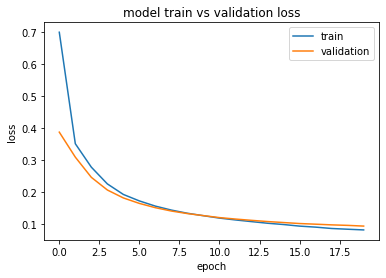

In [38]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
tag_details

In [ ]:
X_train.shape

In [ ]:
X_test[0]

In [ ]:
#This cell contain data information function
def counting_label(string):
    a=0
    for i in range(len(df['label'])):
        if string==df['label'][i]:
            a+=1
    return a

def count(string):
    b,i,o="B-","I-","O-"
    num_of_b=counting_label(b+string)
    num_of_i=counting_label(i+string)
    num_of_o=counting_label(o+string)
    n_of_single_words=num_of_b-num_of_o        
    n_of_double_words=num_of_b-n_of_single_words-num_of_i
    n_of_multiple_words=num_of_i
    return n_of_single_words,n_of_double_words,n_of_multiple_words

def data_details():
    n_of_sen=counting_label("Break")
    n_of_words=len(df["word"])-n_of_sen
    n_of_misc_words=counting_label("0")
    n_of_single_words_name,n_of_double_words_name,n_of_multiple_words_name=count("PER")
    n_of_single_words_loc,n_of_double_words_loc,n_of_multiple_words_loc=count("LOC")
    n_of_single_words_org,n_of_double_words_org,n_of_multiple_words_org=count("ORG")
    n_of_single_words_time,n_of_double_words_time,n_of_multiple_words_time=count("TIME")
    n_of_single_words_unit,n_of_double_words_unit,n_of_multiple_words_unit=count("UNIT")

    d_dict={"Person":[n_of_single_words_name,n_of_double_words_name,n_of_multiple_words_name],
          "Location":[n_of_single_words_loc,n_of_double_words_loc,n_of_multiple_words_loc],
          "Organization":[n_of_single_words_org,n_of_double_words_org,n_of_multiple_words_org],
          "Time":[n_of_single_words_time,n_of_double_words_time,n_of_multiple_words_time],
          "Unit":[n_of_single_words_unit,n_of_double_words_unit,n_of_multiple_words_unit]
         }
    datas=pd.DataFrame(d_dict ,columns = ['Person','Location','Organization','Time','Unit'], index=['Single words','Double words','Multiple words'])

    return n_of_sen,n_of_words,n_of_misc_words,datas

#This function contain the labels distribution
def tag_details():
    tag_distribution = data.groupby("label").size().reset_index(name='counts')
    print(tag_distribution)

In [ ]:
#This function contain evaluation of model
def evaluation(avg):
    p = model.predict(X_test)
    y_pred = np.argmax(p, axis=-1)
    y_real=np.argmax(y_test,axis=-1)
    return f1_score(y_real.flatten(),y_pred.flatten(),average=avg)

In [ ]:
average="macro"
evaluation(average)

In [ ]:
average="micro"
evaluation(average)

In [ ]:
average="weighted"
evaluation(average)

In [ ]:
tag_details()

In [ ]:
p = model.predict(X_test)
y_pred = np.argmax(p, axis=-1)
y_real=np.argmax(y_test,axis=-1)

In [ ]:
print(y_pred[3],y_real[3])

In [ ]:
print(classification_report(y_pred=y_pred.flatten(), y_true=y_real.flatten(),zero_division=0))
# confusion_matrix(y_pred=y_pred_s[0], y_true=y_real_s[0])

In [ ]:
def word_embedding(data):
    l=[]
    for i in data:
        l.append(em_model.wv[i])
    X = pad_sequences(maxlen=max_len, sequences=l, padding="post",value=n_words - 1)
    return X

a="টিকার বদলে স্যালাইন পেয়েছে জার্মানির ৮ হাজার মানুষ!"
b=preprocessing(a).split()
dataX_test=word_embedding(making_list(b))
dataX_test.shape
p=model.predict([dataX_test])

for i in range(len(p)):  
    x=np.argmax(p[i], axis=-1)
    print("{}   {}".format("Word", "Pred"))
    for j in range(len(b)):
        for l,k in label_to_int.items():
            if k==x[j]:
                print("{} -> {}".format(b[j],l))

In [ ]:
model_name="2nd"+".hdf5"
save_model(model, model_name)